# Capstone Project 2: GPCR research trend
## Natural Language Processing of a domain specific literature

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# data with Id, text as fourgram, topic numbers
text_topics = pd.read_csv('./topic_modeling/model_saved/Id_fourgram_topics.csv',index_col=0)
text_topics.head(2)

,Id,fourgram,topics
0,24877594,what we know and do_not know_about the cannabi...,"[22, 16, 11, 10]"
1,16889837,allosteric agonist of 7tm receptor expand the ...,"[22, 14, 4, 17, 12, 10, 3, 20]"


In [3]:
# topic term relation
topic_terms = pd.read_csv('./topic_modeling/model_saved/topic35.csv',index_col=0)
topic_terms.head(2)

,topic,term
0,0,proliferation
1,1,imaging


In [4]:
# data with Id, year, affiliation
df_year_text_affilation = pd.read_csv('./Processed_data/year_text_keywords_affiliation.csv',index_col=0)
df_year_affilation = df_year_text_affilation[['Id','year','affiliation']]
df_year_affilation.head(2)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,year,affiliation
0,24877594,2014.0,[]
1,16889837,2006.0,glaxosmithkline


In [5]:
# publication trend for all papers
alldata = df_year_affilation.merge(text_topics,
                                  left_on = 'Id',
                                  right_on = 'Id',
                                  how = 'left').dropna(subset=['year'])
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323546 entries, 0 to 323645
Data columns (total 5 columns):
Id             323546 non-null int64
year           323546 non-null float64
affiliation    323546 non-null object
fourgram       323546 non-null object
topics         323546 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 14.8+ MB


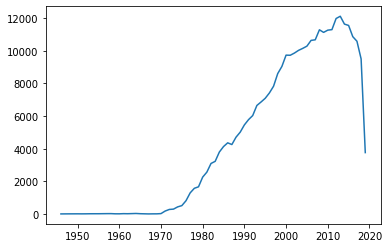

In [6]:
# trend for all publication
year_ct = Counter()
for y in alldata.year:
    year_ct[y] += 1

# sorted by key(year), ordered_year would be a global variable to normalize publication rates
ordered_year = OrderedDict(sorted(year_ct.items(), key=lambda t: t[0]))
totalx = list(ordered_year.keys()) 
totaly = list(ordered_year.values())
plt.plot(totalx,totaly)

### Topic trend

In [8]:
df_year_affilation.shape,text_topics.shape

((323646, 3), (323646, 3))

In [7]:
# convert topic_term to dictionary
topic_dic = {}
for i in range(topic_terms.shape[0]):
    topic_dic[topic_terms.iloc[i].topic] = topic_terms.iloc[i].term


In [8]:
def convert_topic_terms(topics):

    topic_list = topics[1:-1].split(',')
    if topic_list[0] == '':
        return
    term_list = []
    for topic in topic_list:
        term_list.append(topic_dic[int(topic)])
    return term_list

In [9]:
# count topic year
term_year_count = {}
# initiate term_year_count dictionary
for term in topic_dic.values():
    term_year_count[term] = Counter()
    
for i in tqdm(range(text_topics.shape[0])):
    topics = text_topics.iloc[i]['topics']
    term_list = convert_topic_terms(topics)
    
    if term_list:
        for term in term_list:
            term_year_count[term][df_year_affilation.iloc[i]['year']] += 1
        

100%|██████████| 323646/323646 [08:21<00:00, 644.83it/s] 


In [10]:
import json
with open('./ResearchTrend/topic_treand.json','w') as outfile:
    json.dump(term_year_count,outfile)

In [63]:
def plot_topic_trend(topic):
    """
    plot publication number per year normalized to total paper publicated that year
    use term_year_count as global variable to rechieve topic term from topic number
    use ordered_year as global variable to rechieve total paper number that year
    """
    # remove none type key
    cleandict = {k: v for k, v in term_year_count[topic].items() if v > 1}

    ordered_dict = OrderedDict(sorted(cleandict.items(), key=lambda t: t[0]))
    for k,v in ordered_dict.items():
        ordered_dict[k] = v/ordered_year[k]
    
    x = ordered_dict.keys()
    y = ordered_dict.values()

    plt.plot(list(x),list(y))
    plt.title(topic)
    plt.xlabel('publication year')
    plt.ylabel('normalized publication')

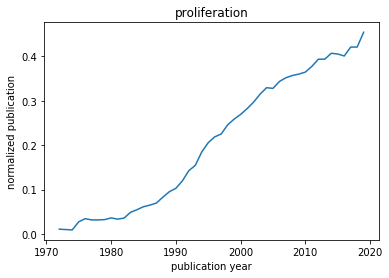

In [64]:
plot_topic_trend(topic_terms.iloc[0].term)

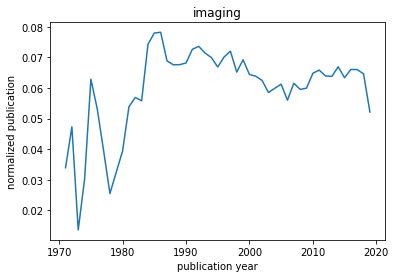

In [65]:
plot_topic_trend(topic_terms.iloc[1].term)

### Receptor research trend

In [11]:
# load all GPCR receptors queried from NCBI
GPCRs = pd.read_csv('./drug_discovery/GPCR_genes.csv',index_col=0)
GPCRs.head(2)

,tax_id,Org_name,GeneID,CurrentID,Status,Symbol,Aliases,description,other_designations,map_location,chromosome,genomic_nucleotide_accession.version,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,orientation,exon_count,OMIM,Unnamed: 17
0,9606,Homo sapiens,3356,0,live,HTR2A,"5-HT2A, HTR2",5-hydroxytryptamine receptor 2A,; 5-hydroxytryptamine receptor 2A|5-HT2 recept...,13q14.2,13,NC_000013.11,46831542.0,46897076.0,minus,4.0,182135.0,NaN
1,9606,Homo sapiens,3358,0,live,HTR2C,"5-HT1C, 5-HT2C, 5-HTR2C, 5HTR2C, HTR1C",5-hydroxytryptamine receptor 2C,; 5-hydroxytryptamine receptor 2C|5-hydroxytry...,Xq23,X,NC_000023.11,114584078.0,114910061.0,plus,7.0,312861.0,NaN


In [12]:
GPCRs = GPCRs[['GeneID','Symbol','Aliases']].fillna('')

In [13]:
GPCRs['Names'] = GPCRs['Symbol'] + ',' + GPCRs['Aliases']
GPCRs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 0 to 1231
Data columns (total 4 columns):
GeneID     790 non-null int64
Symbol     790 non-null object
Aliases    790 non-null object
Names      790 non-null object
dtypes: int64(1), object(3)
memory usage: 30.9+ KB


In [14]:
GPCRs = GPCRs.drop(['Symbol','Aliases'],axis=1)
GPCRs.head(2)

,GeneID,Names
0,3356,"HTR2A,5-HT2A, HTR2"
1,3358,"HTR2C,5-HT1C, 5-HT2C, 5-HTR2C, 5HTR2C, HTR1C"


In [16]:
# process gene names by lowercase and replace '-'
GPCRs['Names'] = GPCRs['Names'].apply(lambda x: x.lower())
GPCRs['Names'] = GPCRs['Names'].apply(lambda x: x.replace('-',''))

In [33]:
def get_ref_year(names): # use row id as input
    """
    get references and years from year reference Id from alldata
    use alldata as global variable
    """
    name_list = names.replace(' ','').split(',')

    years = []
    
    for i in range(alldata.shape[0]):
        for name in name_list:
            if name in alldata['fourgram'].iloc[i]:

                years.append(str(int(alldata['year'].iloc[i])))
                break

    return years              

In [37]:
%%time
from datetime import datetime
years = open('./ResearchTrend/GPCRtreand.txt','w')
for i in range(GPCRs.shape[0]):
    year = get_ref_year(GPCRs['Names'].iloc[i])
    if i % 100 == 0:
        print(datetime.now())
    years.write(' '.join(year))
    years.write('\n')
years.close()

2019-11-08 08:10:07.295111
2019-11-08 08:40:56.279984
2019-11-08 09:13:07.341397
2019-11-08 09:37:34.700352
2019-11-08 10:06:09.600620
2019-11-08 10:29:45.752269
2019-11-08 10:52:01.044536
2019-11-08 11:10:08.362652
CPU times: user 3h 9min 41s, sys: 58 s, total: 3h 10min 39s
Wall time: 3h 16min 44s


In [34]:
GPCR_trends = {}
with open('./ResearchTrend/GPCRtreand.txt','r') as geneTrends:
    for i, line in tqdm(enumerate(geneTrends.readlines())):
        GPCR_trends[GPCRs['GeneID'].iloc[i]] = line.split()

In [38]:
GPCRs

,GeneID,Names
0,3356,"htr2a,5ht2a, htr2"
1,3358,"htr2c,5ht1c, 5ht2c, 5htr2c, 5htr2c, htr1c"
2,2150,"f2rl1,gpr11, par2"
3,3351,"htr1b,5ht1b, 5ht1dbeta, 5ht1b, 5ht1db, htr1d2,..."
4,3350,"htr1a,5ht1a, 5ht1a, 5ht1a, adrb2rl1, adrbrl1, ..."
